# Human brain M1 cells

We localized human brain primary motor cortex (M1) scRNA-seq dataset on huamn dorsolateral prefrontal cortex (DLPFC) 10x Visium ST dataset section 151673 to recover the laminor organization. The raw ST dataset is available at [Github](https://github.com/LieberInstitute/spatialLIBD). The raw scRNA-seq dataset is available at [Allen Brain Atlas](https://portal.brain-map.org/atlases-and-data/rnaseq/human-m1-10x).  The down-sampled barcodes and anndata object of down-sampled scRNA-seq dataset can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1jVJsrXb6a4Hs4UmnDCTxp2OKqcRu3nRZ).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import scanpy as sc
import STALOC
import scipy.sparse as sp

## Read data

In [2]:
st_data_path = '../data/T2_ST/'
adata_ST = sc.read_visium(path=st_data_path, count_file='filtered_feature_bc_matrix.h5')
adata_ST.var_names_make_unique()
Ann_df = pd.read_csv(os.path.join(st_data_path, '151673_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata_ST.obs['layer'] = Ann_df.loc[adata_ST.obs_names, 'Ground Truth']
adata_ST.obs['celltype'] = Ann_df.loc[adata_ST.obs_names, 'Ground Truth']
adata_ST.uns['layer_colors']=['#1f77b4', '#ff7f0e', '#49b192', '#d62728', '#aa40fc', '#8c564b', '#e377c2']
adata_ST.uns['celltype_colors']=['#1f77b4', '#ff7f0e', '#49b192', '#d62728', '#aa40fc', '#8c564b', '#e377c2']
adata_ST=adata_ST[adata_ST.obs['layer'].isna()==False]

In [3]:
adata_ST

View of AnnData object with n_obs × n_vars = 3611 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'layer_colors', 'celltype_colors'
    obsm: 'spatial'

In [4]:
sc_data_path = '../data/T2_sc/'
count=pd.read_csv(os.path.join(sc_data_path, "matrix.csv"), index_col=0)
meta=pd.read_csv(os.path.join(sc_data_path, "metadata.csv"), index_col=0)
adata_sc=sc.AnnData(count, obs=meta)
adata_sc.X=sp.csr_matrix(adata_sc.X)
adata_sc.obs["celltype"]=adata_sc.obs["subclass_label"]
del adata_sc.obs['outlier_call']
used_barcode=pd.read_csv(os.path.join(sc_data_path, "M1_barcode_down_1w.txt"), header=None)[0]
adata_sc=adata_sc[used_barcode]

In [ ]:
#sc_data_path = '../data/T2_sc/'
#adata_sc=sc.read(os.path.join(sc_data_path, "M1_scRNAseq_down_1w.h5ad"))

In [5]:
adata_sc

View of AnnData object with n_obs × n_vars = 10000 × 50281
    obs: 'exp_component_name', 'cluster_label', 'cluster_color', 'cluster_order', 'class_label', 'class_color', 'class_order', 'subclass_label', 'subclass_color', 'subclass_order', 'donor_sex_label', 'donor_sex_color', 'donor_sex_order', 'region_label', 'region_color', 'region_order', 'cortical_layer_label', 'cortical_layer_color', 'cortical_layer_order', 'cell_type_accession_label', 'cell_type_accession_color', 'cell_type_accession_order', 'cell_type_alias_label', 'cell_type_alias_color', 'cell_type_alias_order', 'cell_type_alt_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_order', 'cell_type_designation_label', 'cell_type_designation_color', 'cell_type_designation_order', 'external_donor_name_label', 'external_donor_name_color', 'external_donor_name_order', 'specimen_type', 'full_genotype_label', 'outlier_type', 'celltype'

In [6]:
sc.pp.filter_genes(adata_ST, min_cells=3)
sc.pp.filter_genes(adata_sc, min_cells=3)

## Run model

In [7]:
experiment_path="T2_M1"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [8]:
model = STALOC.model.Model(resolution="low", batch_size=200, train_epoch=10000, cut_steps=0.5, 
                           sf_coord = 6000, rad_cutoff=140/np.sqrt(3), 
                           seed=234, lambdacos = 2, lambdaSWD = 5, lambdalat = 10, lambdarec = 0.1,
                           model_path = "T2_M1/models", data_path = "T2_M1/data", result_path = "T2_M1/results")

In [9]:
model.preprocess(adata_sc, adata_ST)

Finding highly variable genes...
Normalizing and scaling...
Dimensionality reduction via PCA...


In [10]:
model.train()

Begining time:  Wed Sep 20 21:23:07 2023
step 0, total_loss=472.7363, loss_D=5.7295, loss_GAN=3.1327, loss_AE=22.1887, loss_cos=1.9649, loss_LA=21.1817, loss_SWD=6.3940
step 500, total_loss=17.6697, loss_D=1.7391, loss_GAN=4.6290, loss_AE=0.8035, loss_cos=1.0953, loss_LA=0.1640, loss_SWD=0.2350
step 1000, total_loss=14.2487, loss_D=1.7249, loss_GAN=3.9800, loss_AE=0.6651, loss_cos=0.9776, loss_LA=0.0937, loss_SWD=0.1449
step 1500, total_loss=13.1815, loss_D=2.0469, loss_GAN=3.8770, loss_AE=0.6127, loss_cos=0.9496, loss_LA=0.0731, loss_SWD=0.1094
step 2000, total_loss=13.3142, loss_D=1.8631, loss_GAN=3.8642, loss_AE=0.6494, loss_cos=0.9219, loss_LA=0.0697, loss_SWD=0.0831
step 2500, total_loss=12.0203, loss_D=1.8092, loss_GAN=3.7081, loss_AE=0.5687, loss_cos=0.9070, loss_LA=0.0529, loss_SWD=0.0564
step 3000, total_loss=12.3789, loss_D=2.0454, loss_GAN=3.6731, loss_AE=0.5789, loss_cos=0.9740, loss_LA=0.0572, loss_SWD=0.0792
step 3500, total_loss=12.3493, loss_D=1.7650, loss_GAN=3.8221, l

In [11]:
model.eval()

Localized scRNA-seq dataset has been saved!


In [12]:
adata_total = model.adata_total
adata_sc = model.adata_A_input
adata_ST = model.adata_B_input
adata_sc_keep = model.adata_A_keep

In [13]:
adata_sc_keep

AnnData object with n_obs × n_vars = 9841 × 30537
    obs: 'exp_component_name', 'cluster_label', 'cluster_color', 'cluster_order', 'class_label', 'class_color', 'class_order', 'subclass_label', 'subclass_color', 'subclass_order', 'donor_sex_label', 'donor_sex_color', 'donor_sex_order', 'region_label', 'region_color', 'region_order', 'cortical_layer_label', 'cortical_layer_color', 'cortical_layer_order', 'cell_type_accession_label', 'cell_type_accession_color', 'cell_type_accession_order', 'cell_type_alias_label', 'cell_type_alias_color', 'cell_type_alias_order', 'cell_type_alt_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_order', 'cell_type_designation_label', 'cell_type_designation_color', 'cell_type_designation_order', 'external_donor_name_label', 'external_donor_name_color', 'external_donor_name_order', 'specimen_type', 'full_genotype_label', 'outlier_type', 'celltype', 'batch'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'v

## Visualization of the localization results

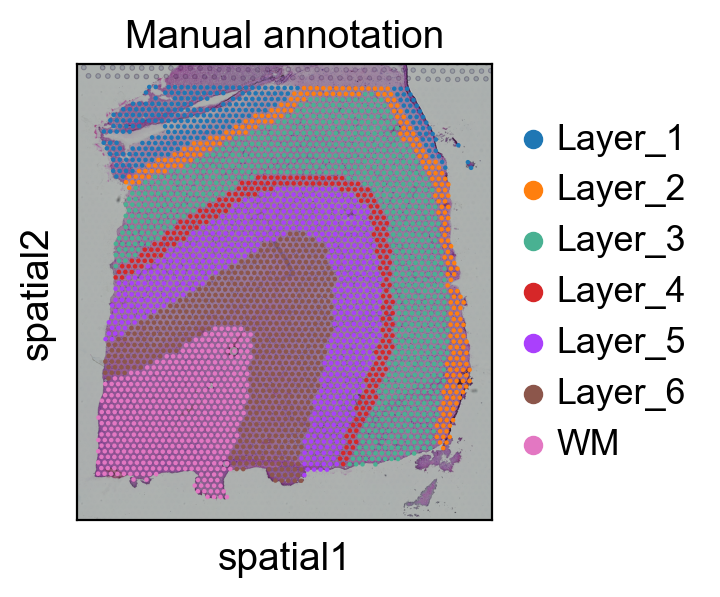

In [15]:
sc.set_figure_params(dpi=100, figsize=(3, 3))
sc.pl.spatial(adata_ST, img_key="hires", color="celltype", title="Manual annotation")

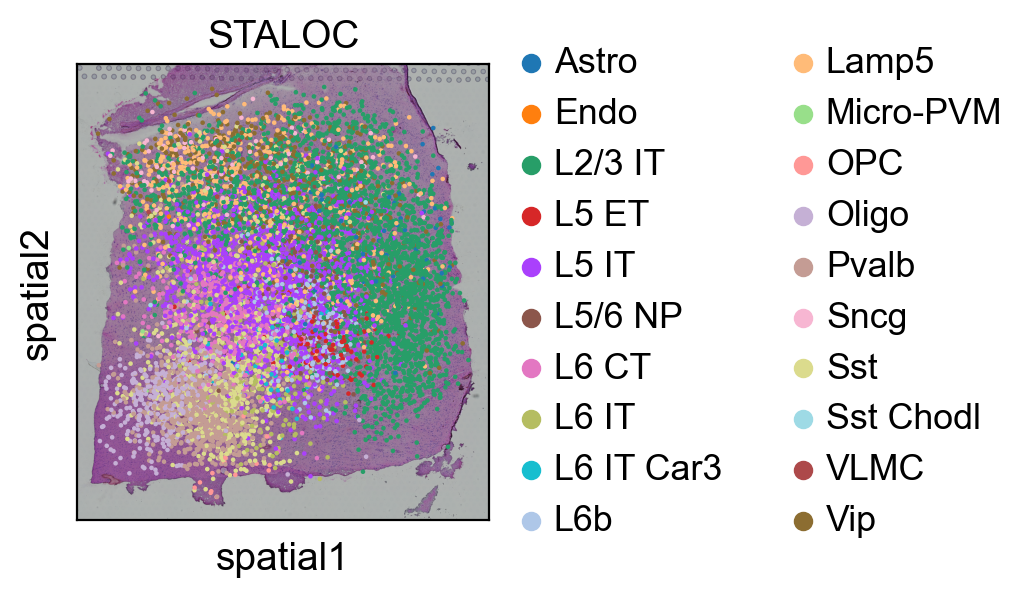

In [16]:
sc.set_figure_params(dpi=100, figsize=(3, 3))
sc.pl.spatial(adata_sc_keep, img_key="hires", color="celltype", title="STALOC")

## Spatial trajectory inference

This part needs [STAGATE](https://github.com/zhanglabtools/STAGATE) package.

In [17]:
import STAGATE
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

------Calculating spatial graph...
The graph contains 181728 edges, 9841 cells.
18.4664 neighbors per cell on average.


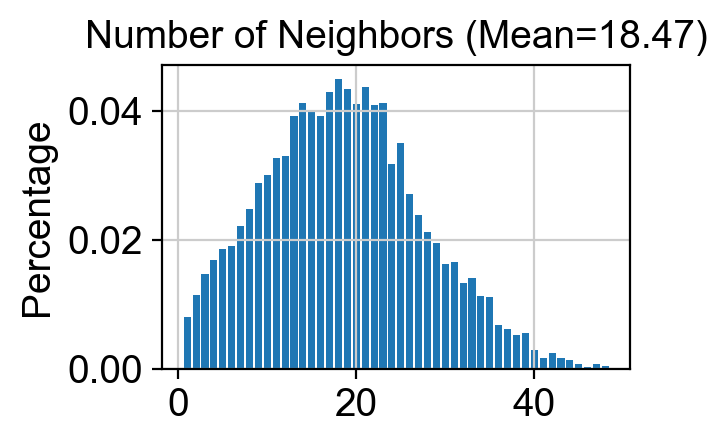

In [18]:
STAGATE.Cal_Spatial_Net(adata_sc_keep, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata_sc_keep)

In [19]:
adata_sc_keep = STAGATE.train_STAGATE(adata_sc_keep, alpha=0)

Size of Input:  (9841, 4000)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [12:27<00:00,  1.49s/it]


In [20]:
sc.pp.neighbors(adata_sc_keep, use_rep='STAGATE')
sc.tl.umap(adata_sc_keep)

<AxesSubplot:title={'center':'UMAP'}, xlabel='UMAP1', ylabel='UMAP2'>

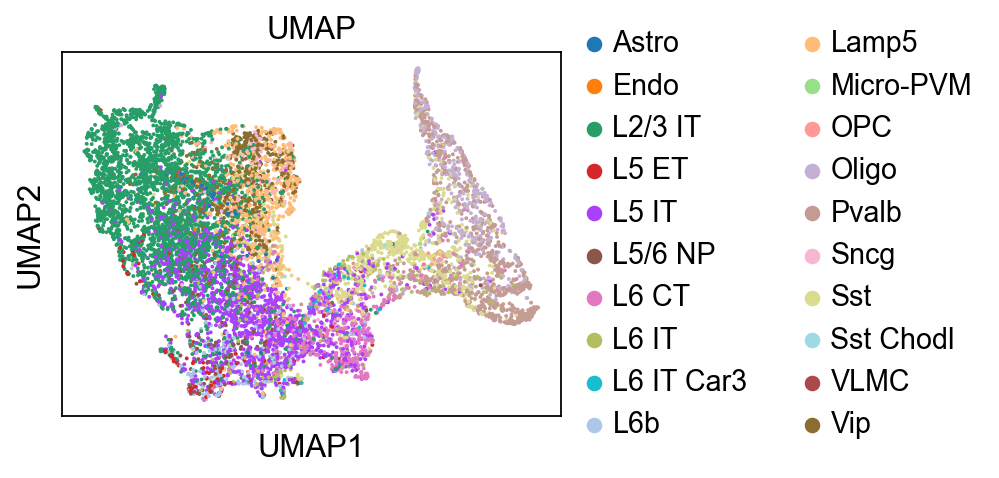

In [21]:
sc.set_figure_params(dpi=80, figsize=(4, 3))
sc.pl.umap(adata_sc_keep, show=False, color="celltype", legend_fontoutline=2, title="UMAP")

In [22]:
pop_label=model.cluster_score.columns
select_pop=pop_label[[3,0,1,12,6,7,10,18,13]]

In [23]:
select_adata_sc_keep=adata_sc_keep.copy()
select_adata_sc_keep=select_adata_sc_keep[select_adata_sc_keep.obs["celltype"].isin(select_pop)]

In [24]:
sc.tl.paga(select_adata_sc_keep, groups='celltype')

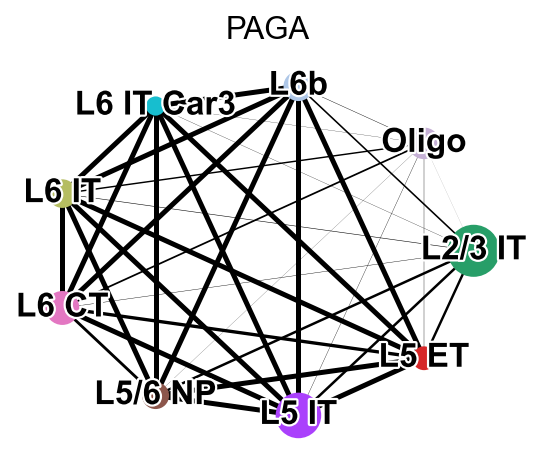

In [25]:
sc.set_figure_params(dpi=80, figsize=(4, 3))
sc.pl.paga(select_adata_sc_keep, fontsize=15, frameon=False, layout='circle', fontoutline=2, edge_width_scale=0.3, 
           threshold=0, show=True, title="PAGA")